# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## Загрузка и подготовка данных

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from numpy.random import RandomState
from tqdm import tqdm

In [2]:
df0 = pd.read_csv('/datasets/geo_data_0.csv')
df1 = pd.read_csv('/datasets/geo_data_1.csv')
df2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
display(df0.head())
display(df1.head())
display(df2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек; (features)
- product — объём запасов в скважине (тыс. баррелей); (target)

In [37]:
tables = [df0, df1, df2]

In [47]:
def info (df):
    print('Общая информация')
    print(df.info())
    print('-'*40)
    print('Описание признаков')
    print(df.describe())
    print('-'*40)
    print('Количество дубликатов в таблице:', df.duplicated().sum())
    print('='*80)

In [48]:
for i in tables:
    info(i)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
----------------------------------------
Описание признаков
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     

Разделяем данные, также удаляем поле 'id', так как не будем использовать его для обучения модели.

In [49]:
def split(df):
    X = df.drop(['product', 'id'], axis = 1)
    y = df['product']
    return X, y

In [50]:
X0, y0 = split(df0)
X1, y1 = split(df1)
X2, y2 = split(df2)

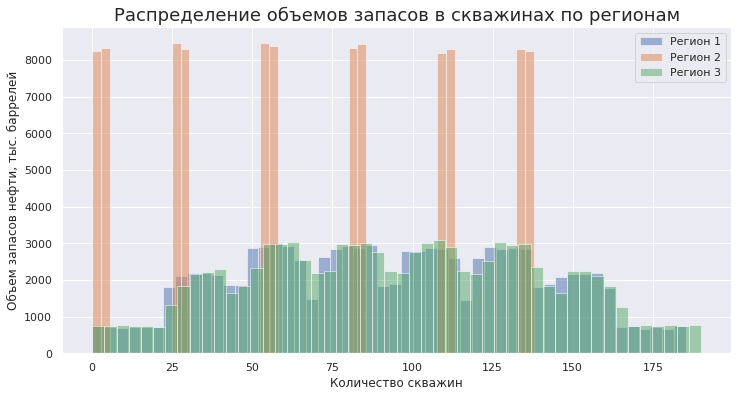

In [77]:
plt.figure(figsize = (12,6))
plt.title('Распределение объемов запасов в скважинах по регионам', size = 18)
plt.xlabel('Количество скважин')
plt.ylabel('Объем запасов нефти, тыс. баррелей')
y0.hist(alpha = 0.5, bins = 50) 
y1.hist(alpha = 0.5, bins = 50)
y2.hist(alpha = 0.5, bins = 50)
plt.legend(['Регион 1', 'Регион 2', 'Регион 3']);

**Выводы**
- В данных нет дубликатов и пропусков.
- Удалили столбец 'id' и разделили данные на фичи и таргет.
- Распределение в регионе 2 ненормальное.
- По условиям задачи не меняем данные.

## Обучение и проверка модели

In [78]:
RNS = 2021

**Разделим данные на обучающую и тестовую выборки.**

In [80]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.25, random_state = RNS)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25, random_state = RNS)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state = RNS)

**Сделаем стандартизацию признаков.**

In [82]:
def scaler(x_train, x_test):
    scaler = StandardScaler()
    scaler.fit(x_train)
    train = scaler.transform(x_train)
    test = scaler.transform(x_test)
    return train, test

In [83]:
X0_train, X0_test = scaler(X0_train, X0_test)
X1_train, X1_test = scaler(X1_train, X1_test)
X2_train, X2_test = scaler(X2_train, X2_test)

**Обучим модели и посмотрим на метрики.**

In [135]:
def lr (x_train, y_train, x_test):
    lr = LinearRegression()
    lr.fit(x_train, y_train)
    predictions = pd.Series(lr.predict(x_test))
    return predictions

In [136]:
pred0 = lr(X0_train, y0_train, X0_test)
pred1 = lr(X1_train, y1_train, X1_test)
pred2 = lr(X2_train, y2_train, X2_test)

In [109]:
metrics = [{'RMSE': (mean_squared_error(y0_test, pred0))**(0.5), 'R2': r2_score(y0_test, pred0), 'predict_mean': pred0.mean()}, 
           {'RMSE': (mean_squared_error(y1_test, pred1))**(0.5), 'R2': r2_score(y1_test, pred1), 'predict_mean': pred1.mean()}, 
           {'RMSE': (mean_squared_error(y2_test, pred2))**(0.5), 'R2': r2_score(y2_test, pred2), 'predict_mean': pred2.mean()}]

In [110]:
pd.DataFrame(metrics)

,RMSE,R2,predict_mean
0,37.584896,0.274169,92.675936
1,0.890342,0.999627,68.838718
2,39.995355,0.200185,94.989112


In [111]:
df1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


**Вывод**
- В датасете по региону 2 признак f2 сильно коррелирует с целевым признаком, поэтому модель получилась почти идеальной. Но если есть такой признак, который позволяет настолько хорошо предсказать объем скважины, есть ли вообще смысл в модели?
- Остальные две модели примерно одинакового качества.

## Подготовка к расчёту прибыли

In [174]:
budget = 10e9
points = 500
best_points = 200
barrel_income = 450000
min_volume = budget/barrel_income/best_points
print('Минимальный объем скважины для для безубыточной разработки:', min_volume)

Минимальный объем скважины для для безубыточной разработки: 111.11111111111111


Во всех регионах средний объем скважины меньше необходимого, соответственно ценность предсказаний модели повышается.

## Расчёт прибыли и рисков 

In [118]:
state = RandomState(RNS)

**Функция для расчета прибыли**

- Выберите скважины с максимальными значениями предсказаний.
- Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитайте прибыль для полученного объёма сырья.

In [164]:
def revenue(target, probabilities, count):
    target.index = probabilities.index
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    profit = (selected.sum()*barrel_income-budget)
    return profit

Прибыль, предсказанная моделями:

In [173]:
print('Регион 1:', np.around(revenue(y0_test, pred0, 200)/1e9, decimals = 3), 'млрд. руб.')
print('Регион 2:', np.around(revenue(y1_test, pred1, 200)/1e9, decimals = 3), 'млрд. руб.')
print('Регион 3:', np.around(revenue(y2_test, pred2, 200)/1e9, decimals = 3), 'млрд. руб.')

Регион 1: 3.137 млрд. руб.
Регион 2: 2.415 млрд. руб.
Регион 3: 2.582 млрд. руб.


**Bootstrap**

In [218]:
def bootstrap (target, probabilities, N, count):
    target.index = probabilities.index
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=N, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index] 
        values.append(revenue(target_subsample, probs_subsample, count))
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    print('Средняя прибыль:', np.around(values.mean()/1e6, decimals = 3), 'млн.руб.')
    print('Доверительный интервал:')
    print('От', np.around(lower/1e6, decimals = 3), 'млн.руб.')
    print('До', np.around(upper/1e6, decimals = 3), 'млн.руб.')
    print('Распределение прибыли:')
    values.hist()
    return values

**Регион 1**

Средняя прибыль: 460.236 млн.руб.
Доверительный интервал:
От -86.638 млн.руб.
До 993.793 млн.руб.
Распределение прибыли:


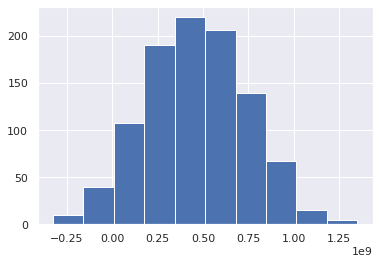

In [219]:
df0_values = bootstrap(y0_test, pred0, 500, 200)

**Регион 2**

Средняя прибыль: 533.898 млн.руб.
Доверительный интервал:
От 106.041 млн.руб.
До 968.524 млн.руб.
Распределение прибыли:


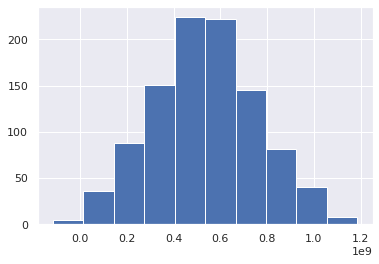

In [220]:
df1_values = bootstrap(y1_test, pred1, 500, 200)

**Регион 3**

Средняя прибыль: 372.937 млн.руб.
Доверительный интервал:
От -158.515 млн.руб.
До 914.134 млн.руб.
Распределение прибыли:


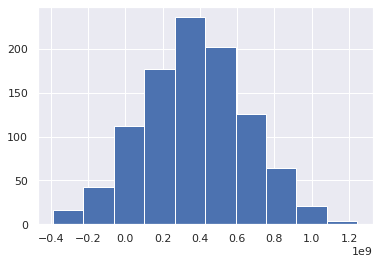

In [221]:
df2_values = bootstrap(y2_test, pred2, 500, 200)

**Риск получения убытка**

In [234]:
print(f'Регион 1: {(df0_values[df0_values<0].shape[0]/df0_values.shape[0]):.2%}')
print(f'Регион 2: {(df1_values[df1_values<0].shape[0]/df1_values.shape[0]):.2%}')
print(f'Регион 3: {(df2_values[df2_values<0].shape[0]/df2_values.shape[0]):.2%}')

Регион 1: 4.60%
Регион 2: 0.40%
Регион 3: 8.80%


**Вывод**
- С учетом рисков, для разработки данных подходит только второй регион. Риск получить отрицательную прибыль составляет 0,4%.
- Средняя прибыль по второму региону - 533.898 млн.руб.
- По региону 2 признак f2 сильно коррелирует с целевым признаком, поэтому модель получилась почти идеальной. 